In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
#from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)
from sklearn.feature_selection import RFECV
import math

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#path ='../file/train.csv'
# Load the dataframe
dataframe = pd.read_csv('train.csv',delimiter=',')

# Remove the Id column from the dataset
#dataframe.drop('ID',axis=1,inplace=True)

print('Shape of the data is: ',dataframe.shape)

dataframe.head()

Shape of the data is:  (52310, 11)


,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [3]:
print(dataframe.describe())
#convert claim as dtype object
dataframe['Claim'] = dataframe['Claim'].astype('object')

                 ID      Duration     Net Sales  Commision (in value)  \
count  52310.000000  52310.000000  52310.000000          52310.000000   
mean    6005.745804     58.256108     48.554673             12.219963   
std     2306.450475    109.138708     60.198589             22.847645   
min     2000.000000     -2.000000   -389.000000              0.000000   
25%     4015.000000     10.000000     19.800000              0.000000   
50%     6002.000000     24.000000     29.500000              0.000000   
75%     8004.000000     57.000000     55.000000             13.380000   
max    10000.000000   4881.000000    682.000000            262.760000   

                Age         Claim  
count  52310.000000  52310.000000  
mean      39.555725      0.166699  
std       13.762473      0.372710  
min        0.000000      0.000000  
25%       33.000000      0.000000  
50%       36.000000      0.000000  
75%       43.000000      0.000000  
max      118.000000      1.000000  


In [4]:
#print(dataframe.isnull().sum())
#filling null values
def fill_null_values(dataset, value):
    nulls = pd.DataFrame(dataset.isnull().sum().sort_values(ascending=False))
    nulls = nulls[nulls>0]
    nulls.columns = ['Null Count']
    nulls.index.name = 'Feature'
    

    for column in nulls[nulls["Null Count"]> 0].index:
        if dataset[column].dtype == np.number and value == 0:
            dataset[column].fillna(dataset[column].mean(), inplace = True)
        elif value == 1:
            dataset[column].fillna(dataset[column].median(), inplace = True)
        else:
            dataset[column].fillna("NA", inplace = True)
    print(dataset.isnull().sum())
    return dataset

dataframe=fill_null_values(dataframe,0)

ID                      0
Agency                  0
Agency Type             0
Distribution Channel    0
Product Name            0
Duration                0
Destination             0
Net Sales               0
Commision (in value)    0
Age                     0
Claim                   0
dtype: int64


In [5]:
#Check CLass Imbalance
def class_imbalance(target):
    class_values = (target.value_counts()/target.value_counts().sum())*100
    return class_values

class_imbalance(dataframe['Claim'])

0    83.330147
1    16.669853
Name: Claim, dtype: float64

In [6]:
#EDA
# Describing all the Numerical Features
dataframe.describe()

,ID,Duration,Net Sales,Commision (in value),Age
count,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000
mean,6005.745804,58.256108,48.554673,12.219963,39.555725
std,2306.450475,109.138708,60.198589,22.847645,13.762473
min,2000.000000,-2.000000,-389.000000,0.000000,0.000000
25%,4015.000000,10.000000,19.800000,0.000000,33.000000
50%,6002.000000,24.000000,29.500000,0.000000,36.000000
75%,8004.000000,57.000000,55.000000,13.380000,43.000000
max,10000.000000,4881.000000,682.000000,262.760000,118.000000


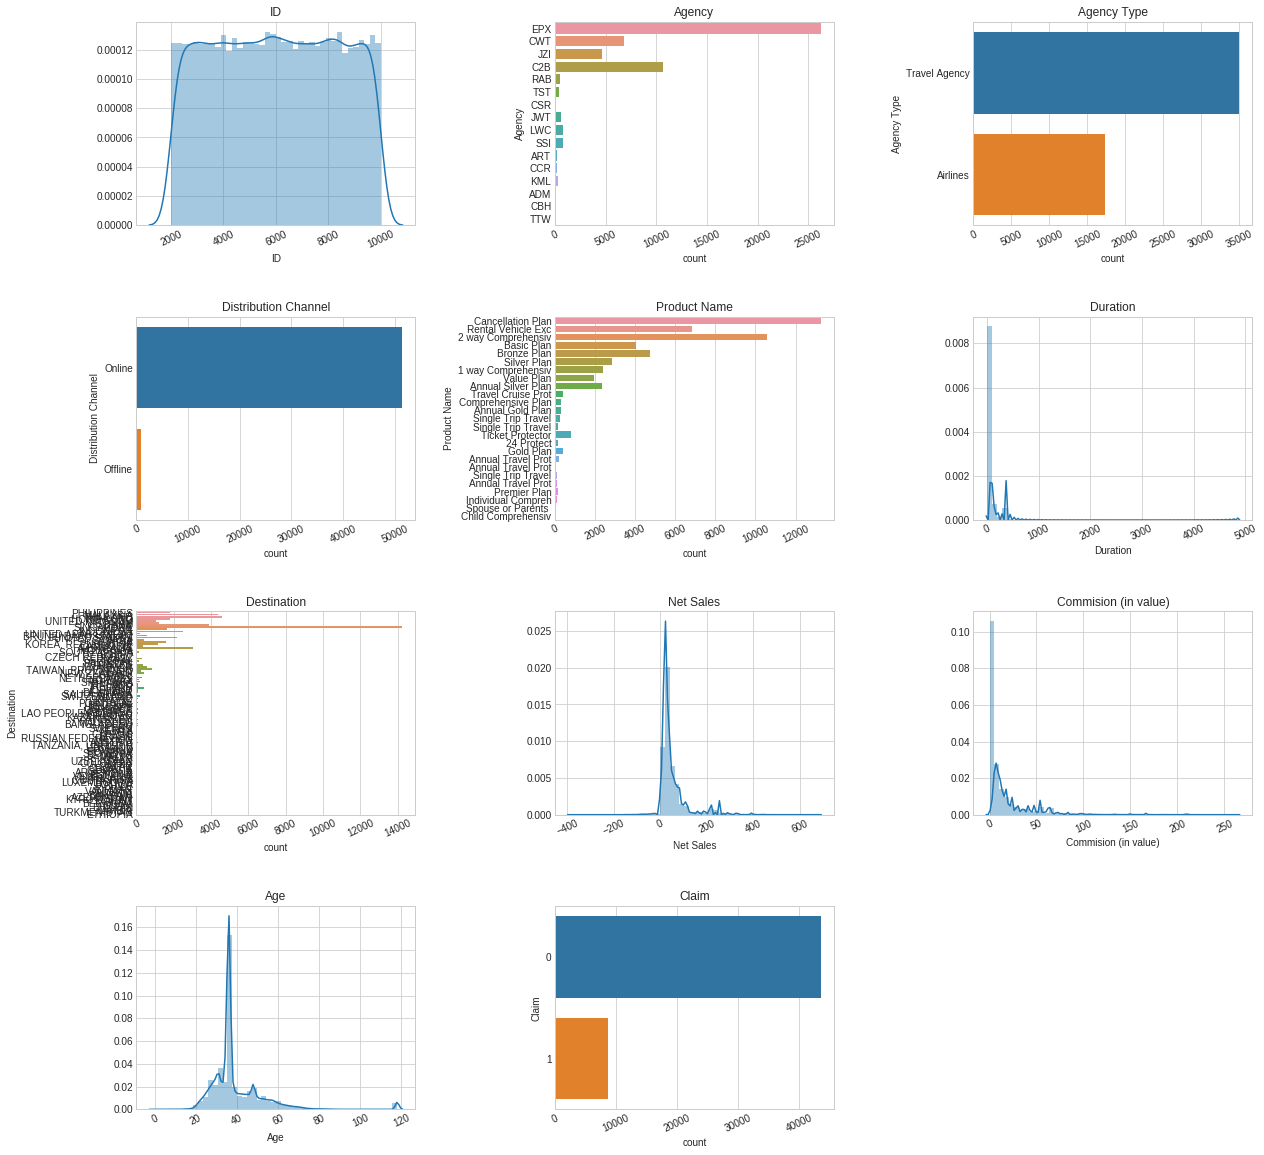

In [7]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(dataframe, cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

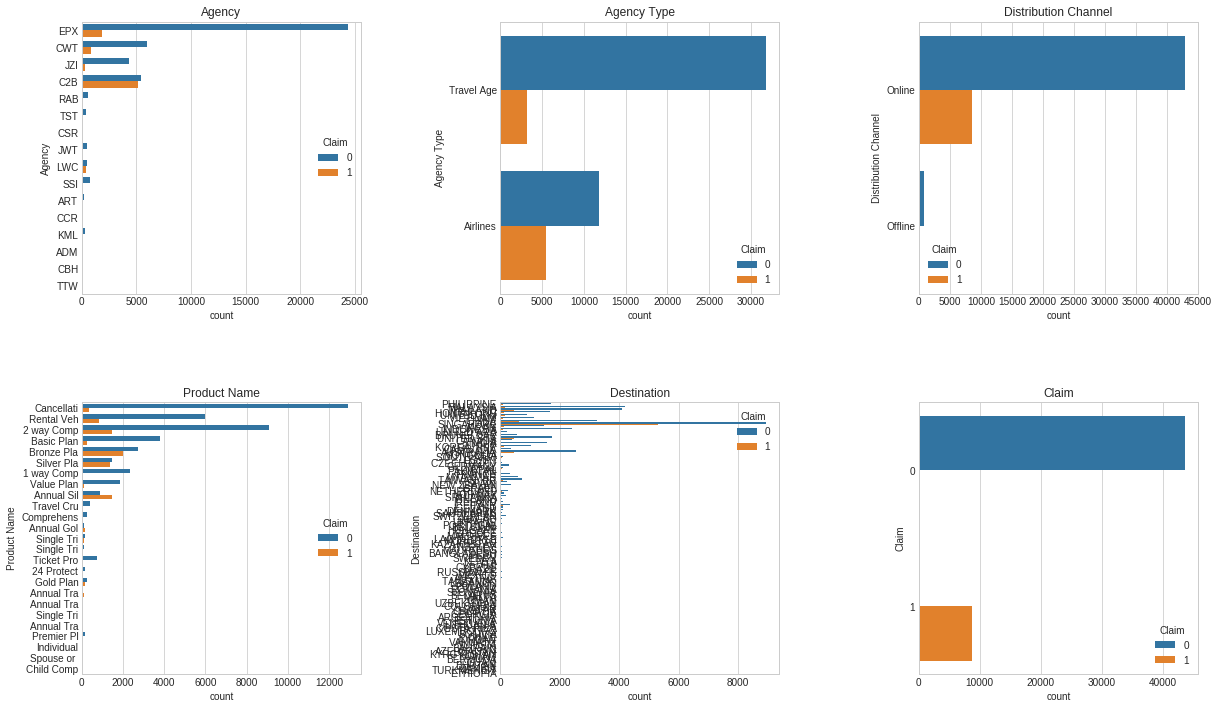

In [8]:
def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, hue=hue, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            
plot_bivariate_bar(dataframe, hue='Claim', cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

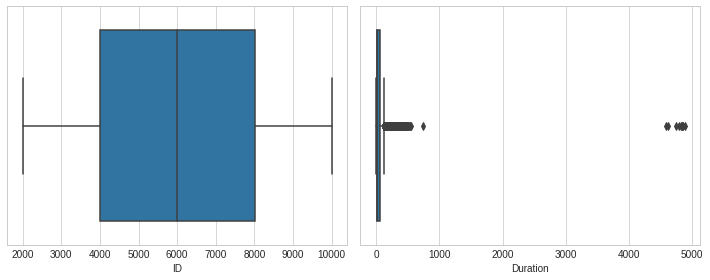

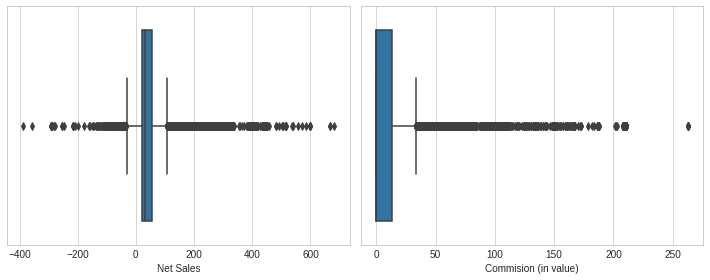

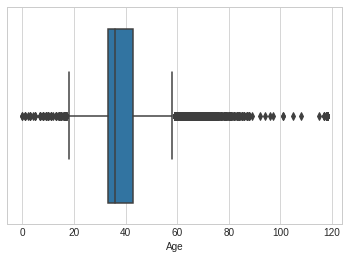

In [9]:
# Function to plot boxplots
def plot_box_plots(dataframe):
    numeric_columns = dataframe.select_dtypes(include=['number']).columns.tolist()
    dataframe = dataframe[numeric_columns]
    
    for i in range(0,len(numeric_columns),2):
        if len(numeric_columns) > i+1:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            sns.boxplot(dataframe[numeric_columns[i]])
            plt.subplot(122)            
            sns.boxplot(dataframe[numeric_columns[i+1]])
            plt.tight_layout()
            plt.show()

        else:
            sns.boxplot(dataframe[numeric_columns[i]])
            
plot_box_plots(dataframe)

In [10]:
# Label Encode train
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def LabelEncode(dataset):
    col_encode = list(dataset.select_dtypes(include=['category', 'object']))
    le = LabelEncoder()
    for feature in col_encode:
        dataset[feature] = le.fit_transform(dataset[feature])
    return dataset

dataframe = LabelEncode(dataframe)
dataframe.shape

(52310, 11)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

def run_model(predictors,target, model):
    x_train,x_test,y_train,y_test = train_test_split(predictors,target,test_size=0.2,random_state=42)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    precision = precision_score(y_test, y_pred)
    print('Classification Report:')
    print(classification_report(y_test,y_pred))
    print('Precision score is',precision_score(y_test, y_pred))
    return precision

features = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
# Predictors
X = dataframe.copy()

# Target
y = dataframe['Claim']

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'Gradient Boosting':GradientBoostingClassifier}


for i in models.items():
    model = i[1]()
    precision = run_model(X[features], y, model)
    print('Precision Score = %.2f' %(precision*100) +' %\nOn Model - \n'+str(i[0]))
    print('===='*20)

Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.97      0.91      8696
          1       0.60      0.21      0.31      1766

avg / total       0.81      0.84      0.81     10462

Precision score is 0.5983870967741935
Precision Score = 59.84 %
On Model - 
Logistic Regression
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      8696
          1       0.75      0.76      0.76      1766

avg / total       0.92      0.92      0.92     10462

Precision score is 0.7502780867630701
Precision Score = 75.03 %
On Model - 
Decision Tree
Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      8696
          1       0.85      0.75      0.80      1766

avg / total       0.93      0.94      0.93     10462

Precision score is 0.8502570694087404
Precision Score = 85.03 %
On Model - 
Random Forest
Classifica

In [12]:
X.columns

Index(['ID', 'Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim'],
      dtype='object')

In [13]:
# Load the dataframe
test1 = pd.read_csv('test.csv')
print(test1.head())


      ID Agency    Agency Type Distribution Channel              Product Name  \
0  17631    EPX  Travel Agency               Online         Cancellation Plan   
1  15064    EPX  Travel Agency               Online  1 way Comprehensive Plan   
2  14139    C2B       Airlines               Online               Bronze Plan   
3  19754    EPX  Travel Agency               Online  2 way Comprehensive Plan   
4  16439    C2B       Airlines               Online               Silver Plan   

   Duration                Destination  Net Sales  Commision (in value)  Age  
0       192                  HONG KONG       18.0                  0.00   36  
1         2                  SINGAPORE       20.0                  0.00   36  
2        13                  SINGAPORE       13.5                  3.38   24  
3       133  TAIWAN, PROVINCE OF CHINA       41.0                  0.00   36  
4         2                  SINGAPORE       30.0                  7.50   32  


In [14]:
# Remove the Id column from the dataset
test = test1.drop('ID',axis=1)

print('Shape of the data is: ',test.shape)
test1.shape


Shape of the data is:  (22421, 9)


(22421, 10)

In [15]:
#dataframe.head()
#print(dataframe.isnull().sum())

# Label Encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def LabelEncode(dataset):
    col_encode = list(dataset.select_dtypes(include=['category', 'object']))
    le = LabelEncoder()
    for feature in col_encode:
        dataset[feature] = le.fit_transform(dataset[feature])
    return dataset



In [16]:
dataframe.columns

Index(['ID', 'Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age',
       'Claim'],
      dtype='object')

In [17]:
test = LabelEncode(test)
test.shape
test1.shape
ID = test1['ID']
test['ID'] = ID
test.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,ID
0,7,1,1,10,192,33,18.0,0.00,36,17631
1,7,1,1,0,2,75,20.0,0.00,36,15064
2,2,0,1,9,13,75,13.5,3.38,24,14139
3,7,1,1,1,133,82,41.0,0.00,36,19754
4,2,0,1,17,2,75,30.0,7.50,32,16439


In [18]:
dataframe.shape
test1.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age
0,17631,EPX,Travel Agency,Online,Cancellation Plan,192,HONG KONG,18.0,0.00,36
1,15064,EPX,Travel Agency,Online,1 way Comprehensive Plan,2,SINGAPORE,20.0,0.00,36
2,14139,C2B,Airlines,Online,Bronze Plan,13,SINGAPORE,13.5,3.38,24
3,19754,EPX,Travel Agency,Online,2 way Comprehensive Plan,133,"TAIWAN, PROVINCE OF CHINA",41.0,0.00,36
4,16439,C2B,Airlines,Online,Silver Plan,2,SINGAPORE,30.0,7.50,32


In [29]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfc_model = RandomForestClassifier()
rfc_model.fit(X[features],y)
rfc_model.score(X_test[features], y_test)
y_pred = rfc_model.predict(X_test[features])
#print("Classification Report")
#print(classification_report(y_test, y_pred))
#print(precision_score(y_test, y_pred))
df_pred = pd.DataFrame({'ID': X_test['ID'].values, 'Claim': y_pred})
df_pred = df_pred[['ID', 'Claim']]
df_pred.to_csv('experiment.csv', index=False)

In [1]:
#submission = pd.concat([ID,prediction['y']],1)

#submission = pd.DataFrame({'ID':test['ID'],'Claim':y_pred}, columns=['ID', 'Claim'])
#filename = 'submission.csv'
#test['Claim'] = y_pred
#submission.to_csv('/Users/ANSARI MASIRA/Downloads/Output/experiment.csv', index=False)